<a href="https://colab.research.google.com/github/JulieOnIsland/Machine_Learning/blob/main/disaster_tweet_classification_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Preprocess the data, build and evaluate NLP models, and make predictions on the test dataset
* source: Zero To Mastery TensorFlow for Deep Learning course (by Daniel Bourke)

```
Model 0: Naive Bayes(baseline)
Model 1: Feed-forward neural network
Model 2: LSTM
Model 3: GRU
Model 4: Bidirectional RNN
Model 5: Conv1D
Model 6: Using pretrained embeddings (transfer learning)
```

In [1]:
# Check gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3a11bd40-0c5f-8a75-5836-0afc112269fb)


In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-21 07:01:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-21 07:01:36 (51.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Preprocessing the data


In [4]:
# Get a text dataset (Kaggle disaster tweet data downloaded)
import pandas as pd
path = '/content/drive/MyDrive/data/'
train_df = pd.read_csv(path + 'disaster_tweet_train.csv')
test_df = pd.read_csv(path + 'disaster_tweet_test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Target labels**

* `0` = not disaster
* `1` = disaster

In [5]:
print(f'total number of training data: {len(train_df)}')
print(f'total number of test data: {len(test_df)}')

total number of training data: 7613
total number of test data: 3263


In [6]:
print(train_df['text'][0])
print(train_df['text'][1])
print(train_df['text'][7612])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)     
# frac = 1: shuffle everything
# shuffle the data because we want the model not to memorize the pattern
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# Check whether our data is balanced or not
train_df.target.value_counts()
print((train_df.target.value_counts() / len(train_df) ) * 100)

0    57.034021
1    42.965979
Name: target, dtype: float64


In [10]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index: random_index + 5].itertuples():
    _, text, target = row        # get rid of the index
    print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
    print(f'Text:\n{text}\n')
    print(f'----------------------------------------------------------\n')


Target: 0 (not real disaster)
Text:
I rate Hazard very highly but his fanboys are among the worst accounts on Twitter.

----------------------------------------------------------

Target: 1 (real disaster)
Text:
Severe Thunderstorm Warnings have been cancelled in central Oklahoma. Still expect 50 mph winds penny sized hail

----------------------------------------------------------

Target: 0 (not real disaster)
Text:
@bellalinn alrighty Hit me up and we'll blaze!!

----------------------------------------------------------

Target: 1 (real disaster)
Text:
Thank you to @scegnews! Our neighborhood looks like a war zone but we had power back in 4 hours!

----------------------------------------------------------

Target: 0 (not real disaster)
Text:
Blazing Hot! Etisalat Free MB For Complete 12 Months: Etisalat Is Giving out 100MB on TECNO Q1 here is the Ime... http://t.co/AVzsYIe1nT

----------------------------------------------------------



In [11]:
# Split data into training and validation sets

from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size = 0.1,       # use 10% of training data for validation sets
    random_state = 42
)

# to_numpy(): pandas method for turning dataframe value into numpy arrays

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Tokenization

In [14]:
# Convert text into numbers
# tokenization / text vectorization
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [15]:
text_vecotrizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = None
                                    )

In [16]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [17]:
# Find the average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000       # max number of words to have in our vocabulary
# total number of vocab
# top 10000 frequent vocabs
# below 10000, <OOV>
max_length = 15                # max length of our sequences
# If one tweet has 30 words, we only see first 15 words of that tweet

In [19]:
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length
                                    )

In [20]:
# Fit the text vectorizer to the training text (only)
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
\n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text:
 Islamic State group in Egypt threatens to kill Croat hostage http://t.co/VdgfXYX3bw

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1279,  265,  484,    4, 5744, 1949,    5,  542, 5883,  509,    1,
           0,    0,    0,    0]])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]        # get the most common words
bottom_5_words=words_in_vocab[-5:]      # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


* [UNK] : words outside of top 10000 (not frequently appeared words)

## Embedding

In [24]:
# Create an Embedding using TensorFlow's embedding layer

from tensorflow.keras import layers
embedding = layers.Embedding(input_dim = max_vocab_length,    # input shape
                             output_dim = 128,                # output shape
                             input_length = max_length  # how long is each input
                             )
embedding

In [25]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
\n\nEmbedded Version:')

# Embed the random sentence 
# Turn positive integers (indexes) into dense vectors of fixed size
# Thus before embedding we need to turn our sentences into numeric form
# And to do that we already defined text vectorizer
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 More than a crush ???????????? WCE @nykaeD_ ?????????? http://t.co/mkJO8x2dKo

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00533642,  0.02275315, -0.02913733, ..., -0.02240806,
         -0.03572235,  0.00267633],
        [-0.02403455, -0.00012401,  0.02796492, ...,  0.0469862 ,
         -0.02376471,  0.04646616],
        [ 0.04587254, -0.04378983,  0.01453221, ...,  0.02774575,
          0.00317079, -0.02277566],
        ...,
        [ 0.04023964, -0.03483325, -0.00590266, ...,  0.00486644,
         -0.02452649,  0.041711  ],
        [ 0.04023964, -0.03483325, -0.00590266, ...,  0.00486644,
         -0.02452649,  0.041711  ],
        [ 0.04023964, -0.03483325, -0.00590266, ...,  0.00486644,
         -0.02452649,  0.041711  ]]], dtype=float32)>

* shape = (1, 15, 128)
    * 1: one sequence
    * 15: 15 tokens
    * 128: 128 long vectors per token (`output_dim` = 128)

In [26]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00533642,  0.02275315, -0.02913733, -0.01263303, -0.01477242,
        -0.01121311, -0.03312246,  0.03584376,  0.02880759, -0.04268605,
         0.040134  , -0.03512094,  0.02610746, -0.02138939, -0.04535457,
         0.04783794,  0.01521856, -0.01828586, -0.01830919, -0.01470264,
         0.0206229 , -0.03708997,  0.04882305, -0.03038664,  0.02892398,
         0.01140849, -0.01832657, -0.01542039,  0.02924171,  0.02374487,
        -0.01955774,  0.04814941,  0.03467575,  0.00141805, -0.04373701,
         0.01720742,  0.00124534,  0.03254298,  0.02685639,  0.03028384,
         0.0048878 , -0.03547919,  0.00299058, -0.00020547, -0.04439661,
        -0.03102088,  0.01324383, -0.016147  ,  0.02637638,  0.02145353,
         0.00699966, -0.0298677 ,  0.03259419,  0.04617885,  0.04653997,
         0.04382536, -0.00619744,  0.01511445, -0.03335291, -0.03543363,
         0.0467797 ,  0.02726236, -0.04460144,  0.0061435 , -0.00537188,
  

# Model 0: Naive Bayes (baseline)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),    # convert words to numbers using tfidf
                    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [30]:
# DIY
def model_evaluate(pred, true):
    count = (pred == true).sum()
    return (count / len(val_labels)) * 100

print('The accuracy of Model_0 is', round(model_evaluate(baseline_preds, val_labels), 2), '%')

The accuracy of Model_0 is 79.27 %


## Creating an evaluation function
* Key: compare y_pred and y_true
* Classification evaluation methods
    * Accuracy
    * Precision
    * Recall
    * F1-score


In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1 score of a binary classification model
    """

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall, and f1-score using weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {'accuracy': model_accuracy,
                     'precision': model_precision,
                     'recall': model_recall,
                     'f1': model_f1}
    return model_results

* Calculating f1-score using "weighted" average:
    * Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label)
    * Take label imbalance into account

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Model 1: Feed-forward neural network (dense model)

In [33]:
# Create a tensorboard callback
# It allows us to track training results of the model
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
     log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

     print(f"Saving TensorBoard log files to: {log_dir}")
     return tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)     # turn the input text into numbers
x = embedding(x)                # create an embedding
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)    # binary classification -> sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [35]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

* What happens if there's no `GlobalAveragePooling1D()` layer after `embedding` layer? 
    
    Look at the dense layer output shape. 

    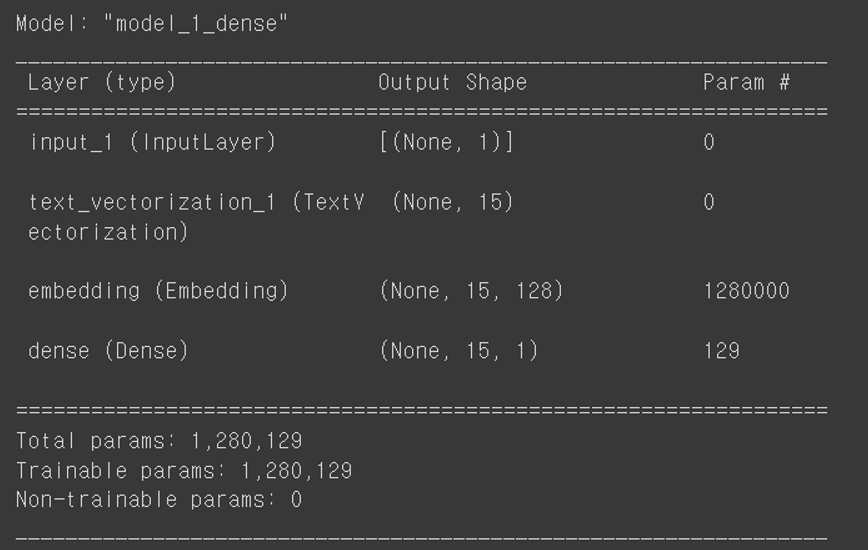

In [36]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [37]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220121-070142
Epoch 1/5
215/215 [==============================] - 3s 5ms/step - loss: 0.6104 - accuracy: 0.6980 - val_loss: 0.5348 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4416 - accuracy: 0.8193 - val_loss: 0.4718 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3473 - accuracy: 0.8603 - val_loss: 0.4577 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2849 - accuracy: 0.8911 - val_loss: 0.4661 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2375 - accuracy: 0.9115 - val_loss: 0.4770 - val_accuracy: 0.7835


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7835


[0.4770285189151764, 0.7834645509719849]

In [39]:
# Make some predictions and evaluate 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.38255745],
       [0.7791915 ],
       [0.997422  ],
       [0.12764242],
       [0.12709261],
       [0.9449638 ],
       [0.9132703 ],
       [0.989749  ],
       [0.9671669 ],
       [0.27514526]], dtype=float32)

In [40]:
model_1_pred_probs.shape

(762, 1)

In [41]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [42]:
# To compare model_1_pred_probs and val_labels,
# we need to convert model pred probabilities to label format (0, 1)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [43]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [44]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.7807800582578167,
 'precision': 0.7872123378365872,
 'recall': 0.7834645669291339}

In [45]:
# Compare baseline results and model_1 results
import numpy as np
results_keys = list(model_1_results.keys())
print('Model 1 results  VS  Baseline results')
for i in range(len(model_1_results)):
    print(model_1_results[results_keys[i]], 'VS', baseline_results[results_keys[i]])

Model 1 results  VS  Baseline results
78.34645669291339 VS 79.26509186351706
0.7872123378365872 VS 0.8111390004213173
0.7834645669291339 VS 0.7926509186351706
0.7807800582578167 VS 0.7862189758049549


# Model 2: LSTM

* Model structure:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (probability -> label)
```

In [46]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)     # [batch, timestep (token), feature (vector)]
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64, activation='tanh')(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
# print(x.shape)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [47]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [48]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [49]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220121-070154
Epoch 1/10
215/215 [==============================] - 5s 8ms/step - loss: 0.2228 - accuracy: 0.9221 - val_loss: 0.5283 - val_accuracy: 0.7835
Epoch 2/10
215/215 [==============================] - 1s 6ms/step - loss: 0.1576 - accuracy: 0.9422 - val_loss: 0.5225 - val_accuracy: 0.7848
Epoch 3/10
215/215 [==============================] - 1s 6ms/step - loss: 0.1291 - accuracy: 0.9527 - val_loss: 0.6856 - val_accuracy: 0.7848
Epoch 4/10
215/215 [==============================] - 1s 6ms/step - loss: 0.1077 - accuracy: 0.9602 - val_loss: 0.8409 - val_accuracy: 0.7874
Epoch 5/10
215/215 [==============================] - 1s 6ms/step - loss: 0.0832 - accuracy: 0.9667 - val_loss: 0.8949 - val_accuracy: 0.7756
Epoch 6/10
215/215 [==============================] - 1s 6ms/step - loss: 0.0660 - accuracy: 0.9720 - val_loss: 1.1264 - val_accuracy: 0.7743
Epoch 7/10
215/215 [==============================] - 1s 6ms/step - loss: 0

In [50]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[6.08063747e-05],
       [7.96259344e-01],
       [9.99954224e-01],
       [1.53261023e-02],
       [1.73971021e-05],
       [9.99712288e-01],
       [1.13245785e-01],
       [9.99965549e-01],
       [9.99955416e-01],
       [4.94748533e-01]], dtype=float32)

In [51]:
model_2_pred_probs.shape

(762, 1)

In [52]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [53]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [54]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7685033747739557,
 'precision': 0.7807932741995605,
 'recall': 0.7729658792650919}

In [55]:
# What happens if we add one more LSTM layer?

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2_edit = tf.keras.Model(inputs, outputs, name='model_2_edit_LSTM')

print(model_2_edit.summary())

model_2_edit.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

model_2_edit_history = model_2_edit.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_edit_LSTM')])

Model: "model_2_edit_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                 

In [56]:
model_2_edit_pred_probs = model_2_edit.predict(val_sentences)

model_2_edit_preds = tf.squeeze(tf.round(model_2_edit_pred_probs))

model_2_edit_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_edit_preds)
model_2_edit_results

{'accuracy': 77.29658792650919,
 'f1': 0.7708425630155245,
 'precision': 0.7747736761679446,
 'recall': 0.7729658792650919}

# Model 3: GRU

In [57]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
# If you want to stack recurrent layers on top of each other, you need return_sequences = True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                

In [59]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

In [60]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220121-070224
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1385 - acc: 0.9648 - val_loss: 0.8617 - val_acc: 0.7651
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0517 - acc: 0.9749 - val_loss: 1.2090 - val_acc: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0428 - acc: 0.9791 - val_loss: 1.6857 - val_acc: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0441 - acc: 0.9772 - val_loss: 1.7110 - val_acc: 0.7572
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0413 - acc: 0.9791 - val_loss: 1.6642 - val_acc: 0.7638


In [61]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[4.0842231e-02],
       [4.5713130e-01],
       [9.9999464e-01],
       [2.4084203e-02],
       [5.5966899e-07],
       [9.9992943e-01],
       [9.8928958e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [8.8836044e-01]], dtype=float32)

In [62]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'f1': 0.7613639638656104,
 'precision': 0.765729922717656,
 'recall': 0.7637795275590551}

# Model 4: Bidirectional RNN


In [64]:
# Build a bidirectional RNN in Tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [65]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [66]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

In [67]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220121-070238
Epoch 1/5
215/215 [==============================] - 9s 17ms/step - loss: 0.0950 - acc: 0.9705 - val_loss: 1.2063 - val_acc: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0446 - acc: 0.9781 - val_loss: 1.2378 - val_acc: 0.7638
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0366 - acc: 0.9797 - val_loss: 1.4427 - val_acc: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0397 - acc: 0.9801 - val_loss: 1.3924 - val_acc: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0372 - acc: 0.9794 - val_loss: 1.5550 - val_acc: 0.7664


In [68]:
# Make predictions with bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:5]

array([[6.6785499e-02],
       [6.7236370e-01],
       [9.9995196e-01],
       [4.0042853e-01],
       [2.6050498e-05]], dtype=float32)

In [69]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [70]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.765614809581862,
 'precision': 0.7661181993158156,
 'recall': 0.7664041994750657}

In [71]:
# Compare model 3 and model 4 results
import numpy as np
results_keys = list(model_3_results.keys())
print('Model 3 results  VS  Model 4 results')
for i in range(len(model_3_results)):
    print(model_3_results[results_keys[i]], 'VS', model_4_results[results_keys[i]])

Model 3 results  VS  Model 4 results
76.37795275590551 VS 76.64041994750657
0.765729922717656 VS 0.7661181993158156
0.7637795275590551 VS 0.7664041994750657
0.7613639638656104 VS 0.765614809581862


# Model 5: Conv1D

In [72]:
# Create 1D convolutional layer
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, 
                  kernel_size=5,     # n-grams
                  activation='relu',
                  padding='same')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

# Get a summary 
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_conv1d')])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220121-070304
Epoch 1/5
215/215 [==============================] - 8s 6ms/step - loss: 0.1182 - acc: 0.9658 - val_loss: 0.8927 - val_acc: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0687 - acc: 0.9752 - val_loss: 1.0013 - val_acc: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0563 - acc: 0.9784 - val_loss: 1.0974 - val_acc: 0.7690
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0522 - acc: 0.9780 - val_loss: 1.1598 - val_acc: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0478 - acc: 0.9796 - val_loss: 1.1539 - val_acc: 0.7598


In [74]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.7024383e-01],
       [9.0627235e-01],
       [9.9999142e-01],
       [3.9481189e-02],
       [3.2741926e-07],
       [9.9830997e-01],
       [8.9482963e-01],
       [9.9999881e-01],
       [1.0000000e+00],
       [9.5769954e-01]], dtype=float32)

In [75]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'f1': 0.7595606050018504,
 'precision': 0.7594918880291538,
 'recall': 0.7598425196850394}

# Model 6: Transfer learning (Universal Sentence Encoder in Tensorflow Hub)

In [77]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence])
embed_samples.shape

TensorShape([1, 512])

In [78]:
embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01157024,  0.02485911,  0.02878048, -0.01271502,  0.0397154 ,
        0.08827759,  0.02680984,  0.05589837, -0.01068729, -0.00597293,
        0.00639323, -0.01819519,  0.00030816,  0.09105889,  0.05874645,
       -0.03180628,  0.01512473, -0.05162928,  0.00991364, -0.06865346,
       -0.04209306,  0.02678978,  0.03011007,  0.00321067, -0.00337968,
       -0.04787357,  0.02266722, -0.00985927, -0.04063614, -0.01292094,
       -0.04666385,  0.056303  , -0.03949257,  0.00517688,  0.02495825,
       -0.07014439,  0.02871507,  0.04947682, -0.00633977, -0.08960193,
        0.02807119, -0.00808361, -0.01360602,  0.05998649, -0.10361786,
       -0.05195374,  0.00232955, -0.02332531, -0.03758105,  0.0332773 ],
      dtype=float32)>

In [79]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],     # here, input can be variable length
                                        dtype='string',
                                        trainable=False,
                                        name='USE')   

In [80]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(1, activation='sigmoid')
], name = 'model_6_USE')

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

# Get a summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [81]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220121-070344
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.6471 - acc: 0.7346 - val_loss: 0.6113 - val_acc: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5807 - acc: 0.7882 - val_loss: 0.5623 - val_acc: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5384 - acc: 0.7951 - val_loss: 0.5310 - val_acc: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5100 - acc: 0.7973 - val_loss: 0.5104 - val_acc: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4899 - acc: 0.8011 - val_loss: 0.4958 - val_acc: 0.7887


In [82]:
# Make predictions with USE TF HUB model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.359222  ],
       [0.67522293],
       [0.84790856],
       [0.35192752],
       [0.63762784],
       [0.73570645],
       [0.82078826],
       [0.85319847],
       [0.73663294],
       [0.20087844]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 78.87139107611549,
 'f1': 0.7877863862721669,
 'precision': 0.7888708504227359,
 'recall': 0.7887139107611548}

In [85]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [86]:
# Add one dense layer
model_6_edit = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name = 'model_6_edit_USE')

# Compile the model
model_6_edit.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['acc'])

# Get a summary
model_6_edit.summary()

Model: "model_6_edit_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
# Train a classifier on top of USE pretrained embeddings
model_6_edit_history = model_6_edit.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_2')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_2/20220121-070359
Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.5037 - acc: 0.7856 - val_loss: 0.4495 - val_acc: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4146 - acc: 0.8146 - val_loss: 0.4441 - val_acc: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4017 - acc: 0.8205 - val_loss: 0.4337 - val_acc: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3925 - acc: 0.8272 - val_loss: 0.4326 - val_acc: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3852 - acc: 0.8316 - val_loss: 0.4317 - val_acc: 0.8123


In [88]:
# Make predictions with USE TF HUB model
model_6_edit_pred_probs = model_6_edit.predict(val_sentences)
model_6_edit_pred_probs[:10]

# Convert prediction probabilities to labels
model_6_edit_preds = tf.squeeze(tf.round(model_6_edit_pred_probs))
model_6_edit_preds[:10]

# Calculate model 6 performance metrics
model_6_edit_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_edit_preds)
model_6_edit_results

{'accuracy': 81.23359580052494,
 'f1': 0.8104722790014789,
 'precision': 0.8155610053499988,
 'recall': 0.8123359580052494}

# Comparing all models

In [100]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0 baseline': baseline_results,
                                  '1 simple dense': model_1_results,
                                  '2 lstm': model_2_results,
                                  '3 gru': model_3_results,
                                  '4 bidirectional': model_4_results,
                                  '5 conv1d': model_5_results,
                                  '6 tf hub use encoder': model_6_edit_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0 baseline,79.265092,0.811139,0.792651,0.786219
1 simple dense,78.346457,0.787212,0.783465,0.780780
2 lstm,77.296588,0.780793,0.772966,0.768503
3 gru,76.377953,0.765730,0.763780,0.761364
4 bidirectional,76.640420,0.766118,0.766404,0.765615
5 conv1d,75.984252,0.759492,0.759843,0.759561
6 tf hub use encoder,81.233596,0.815561,0.812336,0.810472


In [101]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
0 baseline,0.792651,0.811139,0.792651,0.786219
1 simple dense,0.783465,0.787212,0.783465,0.780780
2 lstm,0.772966,0.780793,0.772966,0.768503
3 gru,0.763780,0.765730,0.763780,0.761364
4 bidirectional,0.766404,0.766118,0.766404,0.765615
5 conv1d,0.759843,0.759492,0.759843,0.759561
6 tf hub use encoder,0.812336,0.815561,0.812336,0.810472


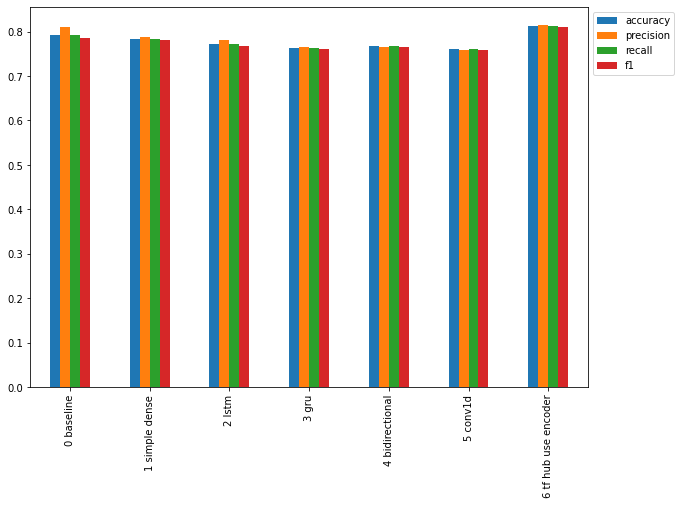

In [103]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

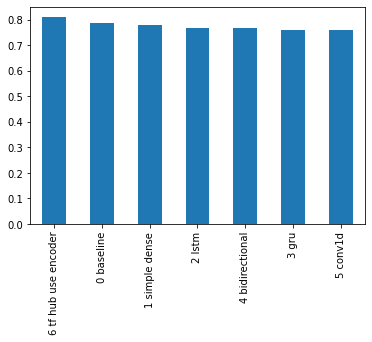

In [111]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar');

# Save and Load the best model

In [134]:
# SavedModel format
model_6_edit.save('model_6_SavedModel_format')

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [135]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [136]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4317 - acc: 0.8123


[0.43170472979545593, 0.8123359680175781]

In [137]:
# Find the most wrong examples
model_6_pretrained = tf.keras.models.load_model('model_6_SavedModel_format')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4317 - acc: 0.8123


[0.43170472979545593, 0.8123359680175781]

In [138]:
# Make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [143]:
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.179185
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.804026
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987508
3,@camilacabello97 Internally and externally scr...,1,0.0,0.210798
4,Radiation emergency #preparedness starts with ...,1,1.0,0.747584


# Find model's most wrong predictions

In [145]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df.target != val_df.pred].sort_values('pred_prob', ascending=False)
most_wrong[:10]       # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.913734
759,FedEx will no longer transport bioterror patho...,0,1.0,0.902113
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.858745
628,@noah_anyname That's where the concentration c...,0,1.0,0.842086
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.832686
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.819655
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.804026
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.780867
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.769608
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.745261


In [147]:
most_wrong[-10:]        # these are false negatives

,text,target,pred,pred_prob
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.058396
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055213
681,'The way you move is like a full on rainstorm ...,1,0.0,0.052689
59,You can never escape me. Bullets don't harm me...,1,0.0,0.052550
221,going to redo my nails and watch behind the sc...,1,0.0,0.049794
233,I get to smoke my shit in peace,1,0.0,0.046633
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.043185
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.038120
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.035574
38,Why are you deluged with low self-image? Take ...,1,0.0,0.033811


In [149]:
# Check the false positives (model predicted 1 when it should've been 0)
for row in most_wrong[:5].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('-----\n')

Target: 0, Pred: 1.0, Prob: 0.9137337803840637
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.902112603187561
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8587448596954346
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

-----

Target: 0, Pred: 1.0, Prob: 0.8420855402946472
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8326864242553711
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-----



In [150]:
# Check the false negatives (model predicted 1 when it should've been 0)
for row in most_wrong[-5:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('-----\n')

Target: 1, Pred: 0.0, Prob: 0.04663271829485893
Text:
I get to smoke my shit in peace

-----

Target: 1, Pred: 0.0, Prob: 0.04318522661924362
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

-----

Target: 1, Pred: 0.0, Prob: 0.03811987116932869
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

-----

Target: 1, Pred: 0.0, Prob: 0.03557366132736206
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, Prob: 0.03381115943193436
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

-----



# Make predictions on the test dataset

In [158]:
test_sentences = test_df.text.to_numpy()
test_sentences[:10]

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       'Apocalypse lighting. #Spokane #wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan',
       "We're shaking...It's an earthquake",
       "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
       'Hey! How are you?', 'What a nice hat?', 'Fuck off!'], dtype=object)

In [160]:
test_sentence_pred_probs = model_6_pretrained.predict(test_sentences)
test_sentence_pred_probs[:10]

array([[0.53187734],
       [0.8367755 ],
       [0.7974652 ],
       [0.92703766],
       [0.9590923 ],
       [0.4728403 ],
       [0.06488388],
       [0.04583222],
       [0.0502747 ],
       [0.06093987]], dtype=float32)

In [161]:
# Convert prediction probabilities to labels
test_sentence_preds = tf.squeeze(tf.round(test_sentence_pred_probs))
test_sentence_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)>

In [162]:
test_df = pd.DataFrame({'text': test_sentences,
                        'pred': test_sentence_preds,
                        'pred_prob': tf.squeeze(test_sentence_pred_probs)})

test_df.head()

,text,pred,pred_prob
0,Just happened a terrible car crash,1.0,0.531877
1,"Heard about #earthquake is different cities, s...",1.0,0.836775
2,"there is a forest fire at spot pond, geese are...",1.0,0.797465
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.927038
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.959092


In [164]:
test_df.tail(10)

,text,pred,pred_prob
3253,Malaysian PM confirms debris is from missing f...,1.0,0.984129
3254,Officials: Alabama home quarantined over possi...,1.0,0.887820
3255,See the 16yr old PKK suicide bomber who detona...,1.0,0.971588
3256,To conference attendees! The blue line from th...,0.0,0.473931
3257,The death toll in a #IS-suicide car bombing on...,1.0,0.988713
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1.0,0.784360
3259,Storm in RI worse than last hurricane. My city...,1.0,0.960392
3260,Green Line derailment in Chicago http://t.co/U...,1.0,0.923559
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1.0,0.523699
3262,#CityofCalgary has activated its Municipal Eme...,1.0,0.682967
